In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("sales_5000000.csv")
df = df[['Order Date', 'Total Profit']] 
df['Order Date'] = pd.to_datetime(df['Order Date'])
daily_df = df.groupby('Order Date')['Total Profit'].sum().reset_index()
weekly_df = daily_df.resample('W', on='Order Date')['Total Profit'].sum().reset_index()
weekly_df.columns = ['Order Date', 'Total Profit']
weekly_df.set_index('Order Date', inplace=True)

In [3]:
Q1 = weekly_df['Total Profit'].quantile( 0.25)
Q3 = weekly_df['Total Profit'].quantile( 0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
weekly_df = weekly_df[(weekly_df['Total Profit'] >= lower_bound) & 
                      (weekly_df['Total Profit'] <= upper_bound)]

In [4]:
train_data, test_data = train_test_split(weekly_df, test_size= 0.2, shuffle=False)

In [5]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[["Total Profit"]])
test_scaled = scaler.transform(test_data[["Total Profit"]])
train_data["Total Profit"] = train_scaled.astype(float)
test_data["Total Profit"] = test_scaled.astype(float)

In [6]:
def create_sequences(data, dates, seq_length):
    X, y, seq_dates = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
        seq_dates.append(dates[i+seq_length])
    return np.array(X), np.array(y), np.array(seq_dates)

seq_length = 12

In [7]:
X_train, y_train, train_dates = create_sequences(
    train_data["Total Profit"].values,
    train_data.index,
    seq_length
)

X_test, y_test, test_dates = create_sequences(
    test_data["Total Profit"].values,
    test_data.index,
    seq_length
)

In [8]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
model = Sequential([
    Bidirectional(LSTM(64, input_shape=(seq_length, 1))),
    Dense(1)
])

In [10]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [11]:
model.compile(optimizer='adam', loss=rmse, metrics=['mae', rmse])

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience= 100, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs= 50, batch_size= 16, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
27/27 [==============================] - 5s 43ms/step - loss: 0.2824 - mae: 0.2442 - rmse: 0.2824 - val_loss: 0.1994 - val_mae: 0.1620 - val_rmse: 0.2092
Epoch 2/50
27/27 [==============================] - 0s 10ms/step - loss: 0.1895 - mae: 0.1553 - rmse: 0.1895 - val_loss: 0.1950 - val_mae: 0.1579 - val_rmse: 0.2044
Epoch 3/50
27/27 [==============================] - 0s 9ms/step - loss: 0.1903 - mae: 0.1546 - rmse: 0.1903 - val_loss: 0.1948 - val_mae: 0.1580 - val_rmse: 0.2043
Epoch 4/50
27/27 [==============================] - 0s 9ms/step - loss: 0.1860 - mae: 0.1514 - rmse: 0.1860 - val_loss: 0.1937 - val_mae: 0.1571 - val_rmse: 0.2030
Epoch 5/50
27/27 [==============================] - 0s 9ms/step - loss: 0.1868 - mae: 0.1512 - rmse: 0.1868 - val_loss: 0.1957 - val_mae: 0.1625 - val_rmse: 0.2034
Epoch 6/50
27/27 [==============================] - 0s 9ms/step - loss: 0.1900 - mae: 0.1537 - rmse: 0.1900 - val_loss: 0.1920 - val_mae: 0.1587 - val_rmse: 0.2001
Epoch 7/50
27/

4/4 [==============================] - 1s 4ms/step
MAPA (Accuracy): 99.42%


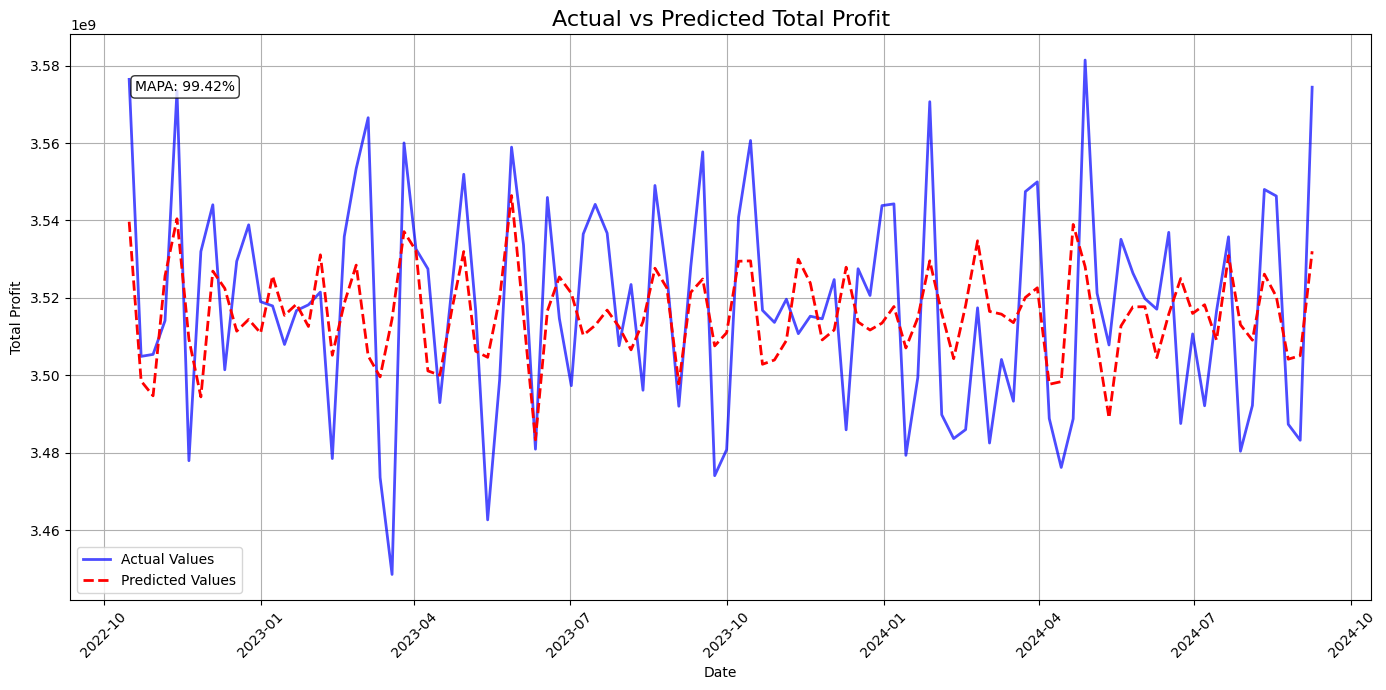

In [13]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
mapa = (1 - mape / 100) * 100
print(f"MAPA (Accuracy): {mapa:.2f}%")

plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_inv, 'b-', linewidth=2, label='Actual Values', alpha=0.7)
plt.plot(test_dates, y_pred_inv, 'r--', linewidth=2, label='Predicted Values')
plt.annotate(f'MAPA: {mapa:.2f}%', 
             xy=(0.05, 0.9), xycoords='axes fraction',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title('Actual vs Predicted Total Profit', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Profit')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mapa = (1 - mape / 100) * 100
print(f"MAPA (Accuracy): {mapa:.2f}%")

MAPA (Accuracy): 53.78%


1/1 [==============================] - 0s 16ms/step


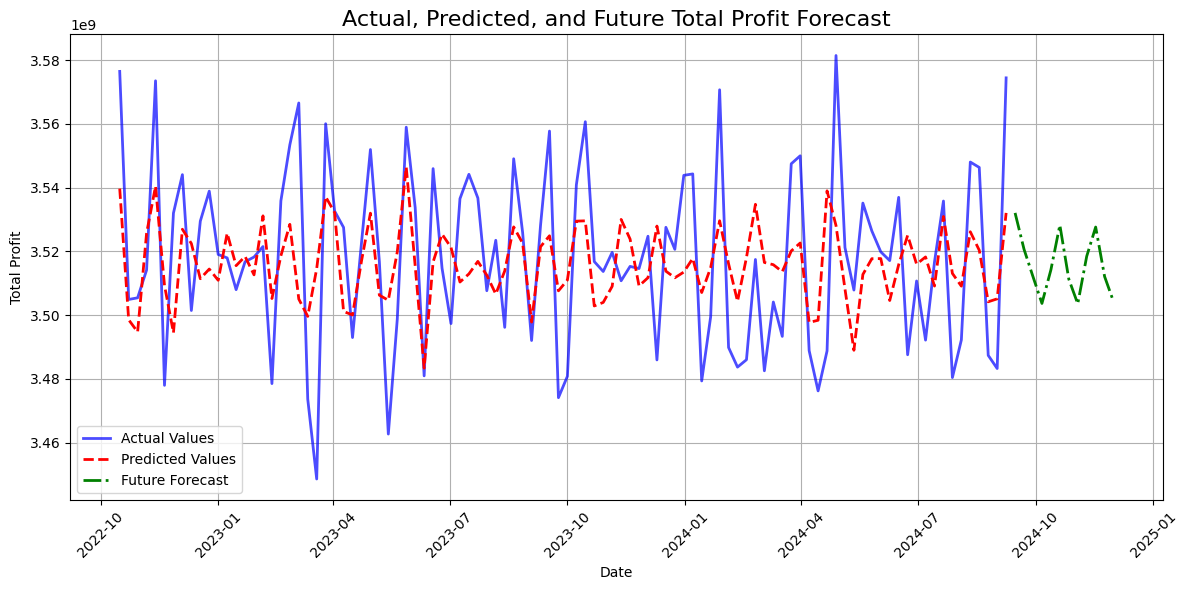

In [15]:
last_sequence = X_test[-1:]
future_preds = []
for _ in range(12):
    pred = model.predict(last_sequence)[0][0]
    future_preds.append(pred)

    last_sequence = np.append(last_sequence[:, 1:, :], [[[pred]]], axis=1)

future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

last_date = test_dates[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=12, freq='W')

plt.figure(figsize=(12, 6))

plt.plot(test_dates, y_test_inv, 'b-', linewidth=2, label='Actual Values', alpha=0.7)
plt.plot(test_dates, y_pred_inv, 'r--', linewidth=2, label='Predicted Values')

plt.plot(future_dates, future_preds, 'g-.', linewidth=2, label='Future Forecast')


plt.title('Actual, Predicted, and Future Total Profit Forecast', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Profit')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()